In [10]:
from IPython.display import HTML
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from scipy import stats as st
from scipy.stats import t
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [11]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [12]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [13]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [14]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [15]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [16]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [17]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [18]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [19]:
stock_fundamentals = market_data
screener = screener_sorted
fundamentals = stock_fundamentals
stock_indexes = sp1500_index_df

spdr_indexes = indexes
spdr_indexes.columns=['Symbol']
vanguard_sectors = sectors
vanguard_sectors.columns=['Symbol']

In [20]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [21]:
sector_performance_Q_smoothed_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]

C:\Users\User\AppData\Local\Temp\ipykernel_12540\3903244463.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['Years'] = years
C:\Users\User\AppData\Local\Temp\ipykernel_12540\3903244463.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['Quarters'] = quarters
C:\Users\User\AppData\Local\Temp\ipykernel_12540\3903244463.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Seasonal Indexes


,03-31,06-30,09-30,12-31
0,Energy ETF,Information Technology ETF,Information Technology ETF,Information Technology ETF
1,Information Technology ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,Financials ETF
2,Utilities ETF,Energy ETF,SP500,Materials ETF
3,SP1500,Materials ETF,Industrials ETF,SP600
4,Industrials ETF,SP1500,SP1500,Consumer Discretionary ETF
5,SP500,SP500,Health Care ETF,SP400
6,SP600,SP600,Utilities ETF,SP500
7,Health Care ETF,SP400,Consumer Staples ETF,SP1500
8,Consumer Staples ETF,Health Care ETF,Financials ETF,Health Care ETF
9,SP400,Communication Services ETF,Materials ETF,Consumer Staples ETF


,03-31,06-30,09-30,12-31
SP1500,-0.010622,0.081757,0.041626,0.049958
SP500,-0.011990,0.080771,0.045646,0.050086
SP600,-0.017768,0.080509,0.019158,0.057970
SP400,-0.019859,0.080174,0.020554,0.051549
Communication Services ETF,-0.032872,0.075995,0.022591,0.017899
Consumer Discretionary ETF,-0.021214,0.120254,0.052510,0.052777
Consumer Staples ETF,-0.018663,0.035480,0.034807,0.045915
Energy ETF,0.055913,0.096281,-0.039735,0.042416
Financials ETF,-0.020711,0.061049,0.030176,0.065446
Health Care ETF,-0.017923,0.078706,0.041045,0.047467


Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison
Current


,06-14
Energy ETF,0.093610
Consumer Staples ETF,-0.087285
Utilities ETF,-0.106792
Materials ETF,-0.127132
Health Care ETF,-0.132440
SP600,-0.137592
Industrials ETF,-0.154625
SP400,-0.169115
SP1500,-0.170565
SP500,-0.172195


standard deviations


,03-31,06-30,09-30,12-31
SP1500,0.134644,0.072380,0.037999,0.110320
SP500,0.127411,0.070450,0.039033,0.106496
SP600,0.199479,0.088447,0.037096,0.179394
SP400,0.157662,0.100224,0.037075,0.138781
Communication Services ETF,0.138244,0.095192,0.045269,0.123434
Consumer Discretionary ETF,0.151791,0.146922,0.083611,0.127243
Consumer Staples ETF,0.096633,0.035421,0.049261,0.063730
Energy ETF,0.369457,0.166709,0.099129,0.202483
Financials ETF,0.192299,0.053666,0.014462,0.140299
Health Care ETF,0.079810,0.054107,0.065798,0.098650


t scores


,03-31,06-30,09-30,12-31
SP1500,-0.035281,0.505153,0.489908,0.202519
SP500,-0.042087,0.512730,0.522980,0.210329
SP600,-0.039834,0.407076,0.230960,0.144515
SP400,-0.056330,0.357747,0.247928,0.166115
Communication Services ETF,-0.106341,0.357027,0.223180,0.064848
Consumer Discretionary ETF,-0.062503,0.366041,0.280865,0.185493
Consumer Staples ETF,-0.086371,0.447954,0.315992,0.322196
Energy ETF,0.067680,0.258283,-0.179260,0.093682
Financials ETF,-0.048166,0.508740,0.933164,0.208614
Health Care ETF,-0.100433,0.650529,0.278976,0.215182


p values


,03-31,06-30,09-30,12-31
SP1500,0.487036,0.675887,0.671106,0.573766
SP500,0.484537,0.678247,0.681422,0.576557
SP600,0.485364,0.644372,0.583899,0.552872
SP400,0.479310,0.627889,0.589904,0.560685
Communication Services ETF,0.461012,0.627646,0.581136,0.523813
Consumer Discretionary ETF,0.477047,0.630688,0.601465,0.567662
Consumer Staples ETF,0.468307,0.657720,0.613641,0.615774
Energy ETF,0.524851,0.593553,0.434579,0.534366
Financials ETF,0.482306,0.677006,0.790214,0.575945
Health Care ETF,0.463168,0.719135,0.600805,0.578288


array([[<AxesSubplot:title={'center':'03-31'}>,
        <AxesSubplot:title={'center':'06-30'}>],
       [<AxesSubplot:title={'center':'09-30'}>,
        <AxesSubplot:title={'center':'12-31'}>]], dtype=object)

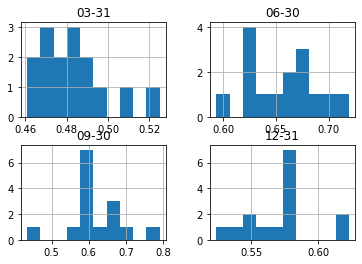

In [22]:
std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]*np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()

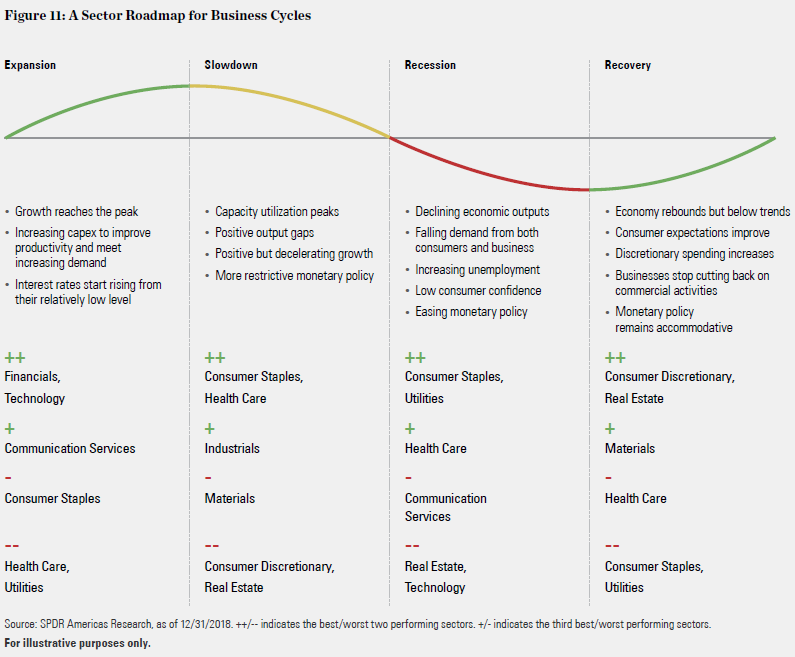

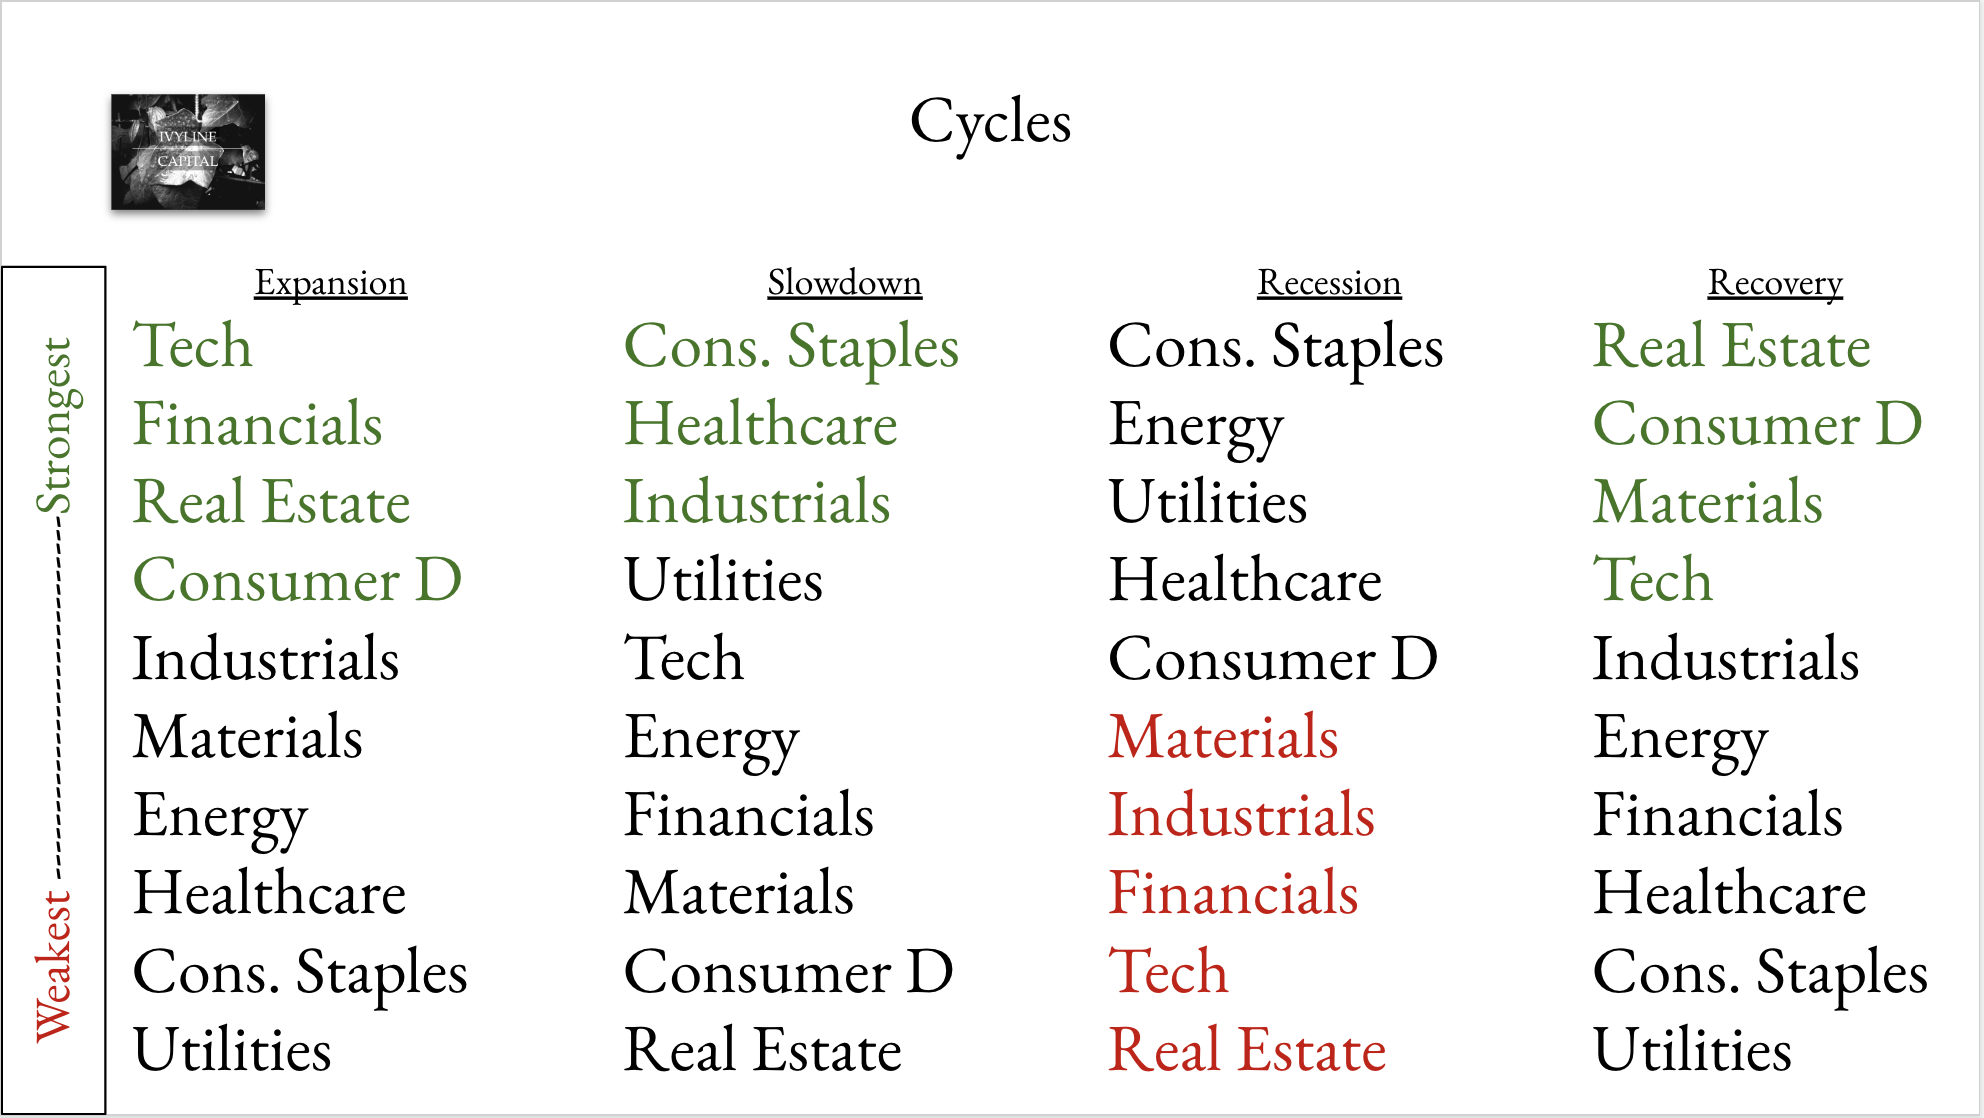

In [23]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

In [24]:
sector_performance_return_pvt = sector_performance_return[sector_performance_return.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performances

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


,Energy ETF,Consumer Staples ETF,Utilities ETF,Materials ETF,Health Care ETF,SP600,Industrials ETF,SP400,SP1500,SP500,Financials ETF,Real Estate ETF,Information Technology ETF,Communication Services ETF,Consumer Discretionary ETF
2017-03-31 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-06-30 00:00:00,-0.078709,0.010040,0.022113,0.026999,0.072895,0.018327,0.042167,0.031752,0.030375,0.030708,0.038955,0.017375,0.041388,-0.024136,0.028386
2017-09-30 00:00:00,0.069612,-0.012346,0.031518,0.066617,0.040565,0.064962,0.052781,0.035020,0.044807,0.045666,0.052789,0.008095,0.083223,0.015498,0.014521
2017-12-31 00:00:00,0.073946,0.059268,0.000687,0.071798,0.018576,0.038747,0.066175,0.074139,0.066880,0.069917,0.073683,0.012742,0.093087,0.000763,0.097848
2018-03-31 00:00:00,-0.078807,-0.073521,-0.033734,-0.072483,-0.020049,-0.011631,-0.033542,-0.003978,-0.021321,-0.024130,-0.015065,-0.086159,0.020711,-0.085669,-0.001942
2018-06-30 00:00:00,0.150528,0.006353,0.053422,0.036210,0.055259,0.106722,-0.008057,0.045520,0.052094,0.047568,-0.011331,0.094633,0.080437,0.035862,0.088528
2018-09-30 00:00:00,0.021911,0.050064,0.019751,0.007338,0.137698,0.032842,0.094874,0.032902,0.070536,0.078236,0.031675,0.000044,0.117719,0.023115,0.066008
2018-12-31 00:00:00,-0.267451,-0.055862,0.009925,-0.154310,-0.108129,-0.193040,-0.183620,-0.172165,-0.142834,-0.137319,-0.138848,-0.058855,-0.174415,-0.143117,-0.162070
2019-03-31 00:00:00,0.178564,0.111156,0.103055,0.126958,0.081835,0.124660,0.183161,0.157497,0.151853,0.144236,0.109942,0.173365,0.217473,0.139541,0.157197
2019-06-30 00:00:00,-0.048754,0.036556,0.035855,0.040951,0.017469,0.010843,0.034436,0.030815,0.039106,0.040369,0.067026,0.015389,0.054745,0.035928,0.040127


,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,2019-09-30 00:00:00,2019-12-31 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,2020-09-30 00:00:00,2020-12-31 00:00:00,2021-03-31 00:00:00,2021-06-30 00:00:00,2021-09-30 00:00:00,2021-12-31 00:00:00,2022-03-31 00:00:00,2022-06-14 00:00:00
0,SP1500,Health Care ETF,Information Technology ETF,Consumer Discretionary ETF,Information Technology ETF,Energy ETF,Health Care ETF,Utilities ETF,Information Technology ETF,Financials ETF,Utilities ETF,Health Care ETF,Information Technology ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,SP600,Energy ETF,Energy ETF,Financials ETF,Information Technology ETF,Energy ETF,Energy ETF
1,SP500,Industrials ETF,Energy ETF,Information Technology ETF,Consumer Discretionary ETF,SP600,Information Technology ETF,Consumer Staples ETF,Industrials ETF,Information Technology ETF,Real Estate ETF,Information Technology ETF,Health Care ETF,Energy ETF,Materials ETF,Energy ETF,SP600,Real Estate ETF,Information Technology ETF,Real Estate ETF,Utilities ETF,Consumer Staples ETF
2,SP600,Information Technology ETF,Materials ETF,SP400,SP400,Real Estate ETF,Industrials ETF,Real Estate ETF,Energy ETF,Materials ETF,Consumer Staples ETF,Financials ETF,Utilities ETF,Information Technology ETF,Information Technology ETF,Financials ETF,Financials ETF,Information Technology ETF,Utilities ETF,Materials ETF,Materials ETF,Utilities ETF
3,SP400,Financials ETF,SP600,Energy ETF,SP600,Consumer Discretionary ETF,SP500,Health Care ETF,Real Estate ETF,SP500,Information Technology ETF,SP1500,Consumer Staples ETF,Materials ETF,Industrials ETF,SP400,Industrials ETF,Communication Services ETF,SP500,Utilities ETF,Consumer Staples ETF,Materials ETF
4,Communication Services ETF,SP400,Financials ETF,Financials ETF,Financials ETF,Information Technology ETF,SP1500,SP500,SP400,Consumer Discretionary ETF,Financials ETF,SP500,Communication Services ETF,SP400,Consumer Staples ETF,Communication Services ETF,Materials ETF,SP500,SP1500,Consumer Staples ETF,Financials ETF,Health Care ETF
5,Consumer Discretionary ETF,SP500,Industrials ETF,Materials ETF,Health Care ETF,Health Care ETF,Consumer Discretionary ETF,Financials ETF,Consumer Discretionary ETF,SP1500,SP500,Communication Services ETF,SP500,Communication Services ETF,Communication Services ETF,Industrials ETF,Real Estate ETF,Health Care ETF,Health Care ETF,SP500,Industrials ETF,SP600
6,Consumer Staples ETF,SP1500,SP500,SP500,SP1500,Utilities ETF,Consumer Staples ETF,SP1500,SP1500,Consumer Staples ETF,SP1500,SP600,SP1500,SP600,SP500,Consumer Discretionary ETF,SP400,SP1500,Real Estate ETF,SP1500,Health Care ETF,Industrials ETF
7,Energy ETF,Consumer Discretionary ETF,SP1500,SP1500,SP500,SP1500,SP400,Communication Services ETF,SP500,Communication Services ETF,Industrials ETF,Materials ETF,Consumer Discretionary ETF,SP1500,SP1500,Materials ETF,Communication Services ETF,Financials ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,SP500,SP400
8,Financials ETF,Materials ETF,Health Care ETF,Industrials ETF,Industrials ETF,SP500,SP600,Materials ETF,Communication Services ETF,Utilities ETF,Consumer Discretionary ETF,SP400,Real Estate ETF,SP500,SP400,Information Technology ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,Consumer Staples ETF,Industrials ETF,SP1500,SP1500
9,Health Care ETF,Utilities ETF,SP400,Consumer Staples ETF,Utilities ETF,SP400,Financials ETF,Consumer Discretionary ETF,Materials ETF,Industrials ETF,Communication Services ETF,Industrials ETF,SP400,Industrials ETF,Health Care ETF,SP1500,SP1500,Materials ETF,Communication Services ETF,Health Care ETF,SP600,SP500


In [25]:
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)

Comparative to Seasonal Indexes, tells you who is over or underperforming.
This is Seasonal Index - Extrapolated Current Quarter.
+: seasonal > current
-: current > seasonal
Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison


,2022-06-14
Information Technology ETF,0.101468
Consumer Discretionary ETF,0.100144
Energy ETF,0.080032
Materials ETF,0.068776
SP1500,0.067882
SP500,0.067058
SP600,0.066839
SP400,0.066560
Health Care ETF,0.065333
Communication Services ETF,0.063069


C:\Users\User\AppData\Local\Temp\ipykernel_12540\2163343643.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['Years'] = years
C:\Users\User\AppData\Local\Temp\ipykernel_12540\2163343643.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['Quarters'] = quarters
C:\Users\User\AppData\Local\Temp\ipykernel_12540\2163343643.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,2019-09-30 00:00:00,2019-12-31 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,2020-09-30 00:00:00,2020-12-31 00:00:00,2021-03-31 00:00:00,2021-06-30 00:00:00,2021-09-30 00:00:00,2021-12-31 00:00:00,2022-03-31 00:00:00,2022-06-14 00:00:00
0,SP1500,Utilities ETF,Energy ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,Energy ETF,Health Care ETF,Utilities ETF,Information Technology ETF,Utilities ETF,Real Estate ETF,Health Care ETF,Health Care ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,Energy ETF,Energy ETF,Real Estate ETF,Energy ETF,Real Estate ETF,Energy ETF,Information Technology ETF
1,SP500,Health Care ETF,SP600,Energy ETF,SP400,Utilities ETF,Energy ETF,Real Estate ETF,Real Estate ETF,Financials ETF,Utilities ETF,Information Technology ETF,Consumer Staples ETF,Energy ETF,Materials ETF,SP600,SP600,Communication Services ETF,Financials ETF,Utilities ETF,Utilities ETF,Consumer Discretionary ETF
2,SP600,Industrials ETF,Materials ETF,Industrials ETF,Information Technology ETF,SP600,Industrials ETF,Consumer Staples ETF,Industrials ETF,Consumer Staples ETF,Consumer Staples ETF,Communication Services ETF,Information Technology ETF,Information Technology ETF,Communication Services ETF,Financials ETF,Financials ETF,Energy ETF,Real Estate ETF,Materials ETF,Materials ETF,Energy ETF
3,SP400,Financials ETF,Financials ETF,Information Technology ETF,SP600,Real Estate ETF,Information Technology ETF,Health Care ETF,Consumer Discretionary ETF,Industrials ETF,Financials ETF,SP1500,Utilities ETF,SP400,Industrials ETF,Communication Services ETF,Materials ETF,Financials ETF,Utilities ETF,Information Technology ETF,Consumer Staples ETF,Materials ETF
4,Communication Services ETF,Consumer Staples ETF,Information Technology ETF,SP400,Financials ETF,Health Care ETF,SP500,Communication Services ETF,SP400,Communication Services ETF,SP600,SP500,Communication Services ETF,Materials ETF,Consumer Staples ETF,SP400,Industrials ETF,Health Care ETF,Health Care ETF,Consumer Staples ETF,Financials ETF,SP1500
5,Consumer Discretionary ETF,SP400,SP400,SP500,Health Care ETF,Consumer Staples ETF,SP1500,SP500,Communication Services ETF,SP500,Communication Services ETF,Financials ETF,SP500,Communication Services ETF,Information Technology ETF,Industrials ETF,Communication Services ETF,SP500,SP1500,SP500,Health Care ETF,SP500
6,Consumer Staples ETF,SP500,Industrials ETF,SP1500,SP1500,SP1500,Consumer Staples ETF,SP1500,SP1500,Materials ETF,SP400,SP600,SP1500,SP600,SP400,Consumer Discretionary ETF,Real Estate ETF,SP1500,SP500,SP1500,Industrials ETF,SP600
7,Energy ETF,SP1500,SP1500,Consumer Staples ETF,SP500,Consumer Discretionary ETF,SP600,Financials ETF,SP500,SP1500,SP500,Industrials ETF,Consumer Discretionary ETF,SP1500,SP500,Materials ETF,SP400,Consumer Staples ETF,Communication Services ETF,Consumer Discretionary ETF,SP500,SP400
8,Financials ETF,Materials ETF,SP500,Materials ETF,Industrials ETF,SP500,Consumer Discretionary ETF,Materials ETF,Materials ETF,SP400,SP1500,SP400,Real Estate ETF,Industrials ETF,SP1500,SP1500,Consumer Discretionary ETF,Information Technology ETF,SP400,Industrials ETF,SP1500,Health Care ETF
9,Health Care ETF,Real Estate ETF,Health Care ETF,Financials ETF,Utilities ETF,SP400,SP400,Consumer Discretionary ETF,SP600,Real Estate ETF,Energy ETF,Energy ETF,SP400,SP500,Health Care ETF,SP500,SP1500,Industrials ETF,SP600,Health Care ETF,Real Estate ETF,Communication Services ETF


In [26]:
index_performance = []
for v in spdr_indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=spdr_indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=spdr_indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

,Index,Symbol,risk_trend_factor
0,SP500,SPY,-3.321707
1,SP1500,SPTM,-3.358764
2,SP400,MDYG,-4.591661
3,SP600,SLY,-4.866667


In [27]:
sector_performance = []
for v in vanguard_sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted

,Symbol,risk_trend_factor,Sector
3,VDE,1.395093,Energy ETF
2,VDC,-2.027309,Consumer Staples ETF
10,VPU,-2.036765,Utilities ETF
8,VAW,-2.726447,Materials ETF
9,VNQ,-2.883868,Real Estate ETF
5,VHT,-2.889925,Health Care ETF
4,VFH,-4.046674,Financials ETF
6,VIS,-4.146982,Industrials ETF
1,VCR,-4.247322,Consumer Discretionary ETF
7,VGT,-4.508045,Information Technology ETF


Rolling Quarterly Mean Return


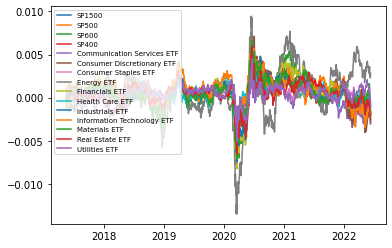

In [28]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


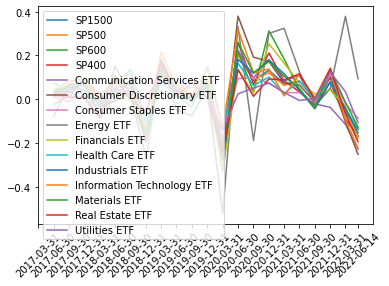

In [29]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


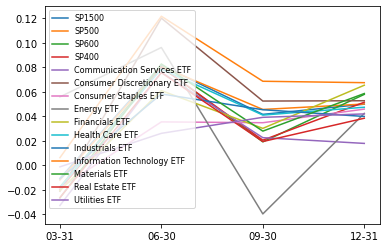

In [30]:
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()

In [31]:
threshold = .975

In [32]:
screener_sorted_ = screener_sorted.reset_index().merge(stock_indexes,on='Symbol',how='left')

screener_good = screener_sorted_[screener_sorted_['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [33]:
risk_trend_threshold

0.8074748903068228

In [34]:
stock_sectors = stock_fundamentals['sector']

In [35]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener[['risk_trend_factor']].merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']
temp_sm = temp_sm.merge(spdr_indexes.reset_index(), on='index', how='left')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index','index_Symbol']
temp_sm.index = sector_merged['Symbol']

for spdr_ in range(0,len(spdr_indexes['Symbol'].values)):
    spdr__ = spdr_indexes['Symbol'].values[spdr_]
    spdr__i = spdr_indexes['Symbol'].index[spdr_]
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__

C:\Users\User\AppData\Local\Temp\ipykernel_12540\2744307430.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

array([[<AxesSubplot:title={'center':'risk_trend_factor'}>]], dtype=object)

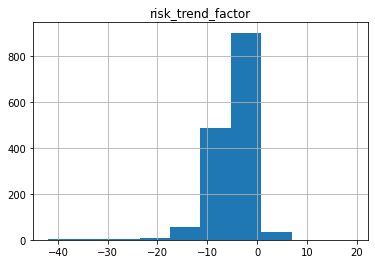

In [36]:
screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [37]:
len(screener)

1520

In [38]:
risk_screened = screener_good[(screener_good['risk_trend_factor']>risk_trend_threshold) & (screener_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
display(risk_screened[['Symbol','latest_p','risk_trend_factor','adf','hurst','Sector','Market Index','vol_30d_2yr']])

Index(['Symbol', 'max_2y', 'min_2y', 'std_2y', 'mean_2y', 'max_1y', 'min_1y',
       'std_1y', 'mean_1y', 'latest_p', '2yr_close_0pct', '2yr_close_2pct',
       '2yr_close_9pct', '2yr_close_25pct', '2yr_close_50pct',
       '2yr_close_75pct', '2yr_close_91pct', '2yr_close_98pct',
       '2yr_close_100pct', '1yr_close_0pct', '1yr_close_2pct',
       '1yr_close_9pct', '1yr_close_25pct', '1yr_close_50pct',
       '2yr_close_75pct', '1yr_close_91pct', '1yr_close_98pct',
       '1yr_close_100pct', 'risk_trend_factor', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr',
       'pct_2yr', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'vol_30d', 'vol_30d_2yr', 'volume_factor',
       'adf', 'hurst', 'Market Index', 'Sector'],
      dtype='object')


,Symbol,latest_p,risk_trend_factor,adf,hurst,Sector,Market Index,vol_30d_2yr,vol_30d_2yr
0,ACC,64.419998,19.217024,0.979637,0.418255,error,SP400,13781055000.0,13781055000.0
1,MTOR,36.0,5.543488,0.304331,0.434725,Consumer Cyclical,SP600,7888381900.0,7888381900.0
2,Y,832.0,2.342256,0.38518,0.458449,Financial Services,SP400,828602100.0,828602100.0
3,TWI,19.15,1.92163,0.891295,0.499041,Industrials,SP600,5400736000.0,5400736000.0
4,PBF,38.919998,1.908312,0.699548,0.555964,Energy,SP600,47517805800.0,47517805800.0
5,SAFM,207.410004,1.772278,0.669942,0.477196,Consumer Defensive,SP400,2596619200.0,2596619200.0
6,MPC,102.669998,1.736425,0.977688,0.523103,Energy,SP500,72756266000.0,72756266000.0
7,DVN,70.589996,1.66933,0.988553,0.552856,Energy,SP500,121752263500.0,121752263500.0
8,VLO,133.75,1.628343,0.922874,0.537334,Energy,SP500,46297639500.0,46297639500.0
9,COP,111.489998,1.627301,0.980711,0.490397,Energy,SP500,96861604200.0,96861604200.0


In [39]:

screened_final_set = risk_screened

In [40]:
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [41]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

In [42]:
list_ = []
for i in index_risk_sorted['Symbol'].values:
    list_.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_.append(i)
for i in screened_final_set['Symbol'].values:
    list_.append(i)
indexes = np.unique(list_, return_index=True)[1]
list__ = [list_[index] for index in sorted(indexes)]

In [43]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

In [44]:
dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

In [45]:
dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [46]:
def evaluate_ets(npa_):
    train,test,model_func,F1,F2 = npa_
    
    model=model_func(np.log(train),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()
    
    fc_ets_ = np.exp(model.forecast(13)) #inverting the Log
    
    rmse_ = mean_squared_error(test, fc_ets_, squared=True)
    return([rmse_])

In [47]:
completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

nominal, pct_change, pct_change().cumsum
Market volatility


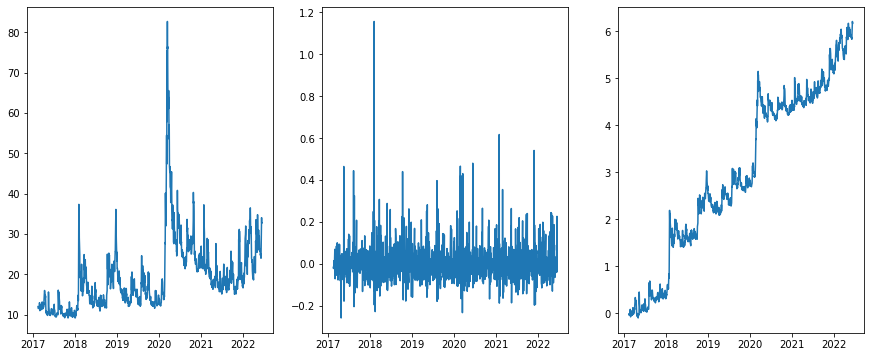

Consumer Confidence


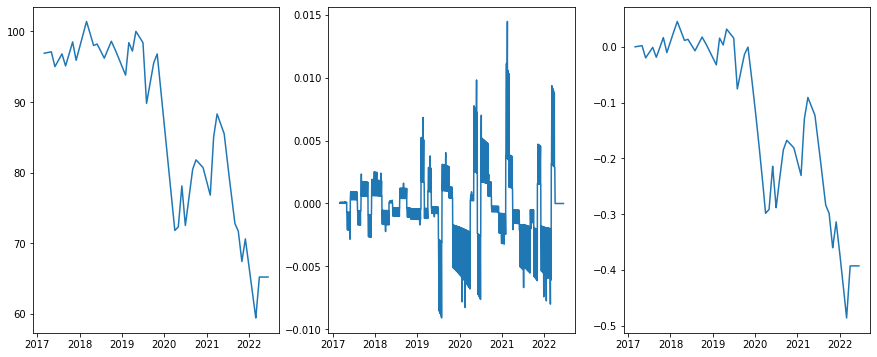

Unemployment


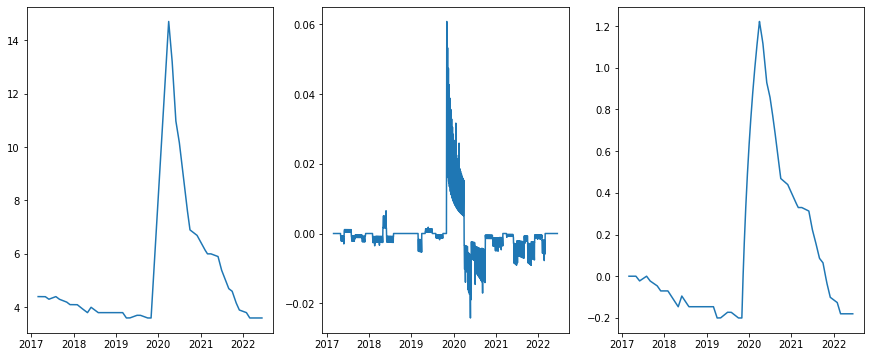

Inflation


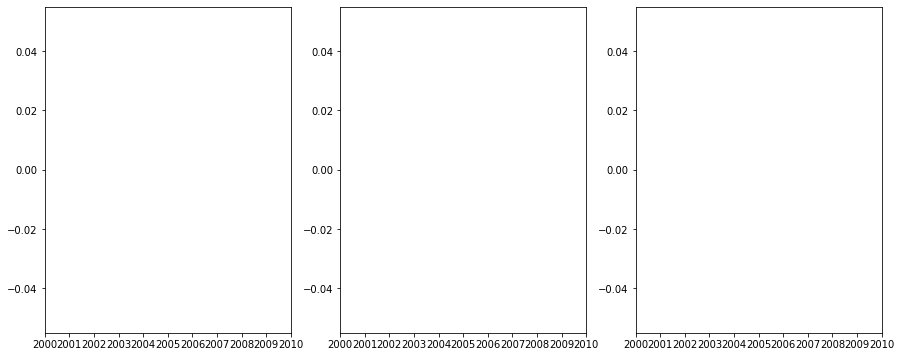

Interest Rates


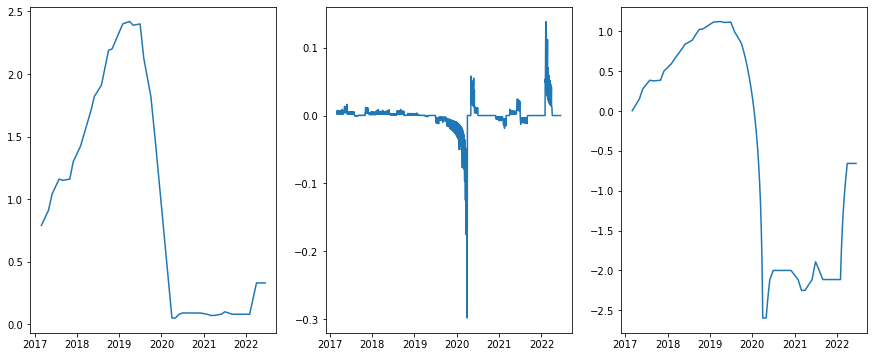

10 Year to 3 Month


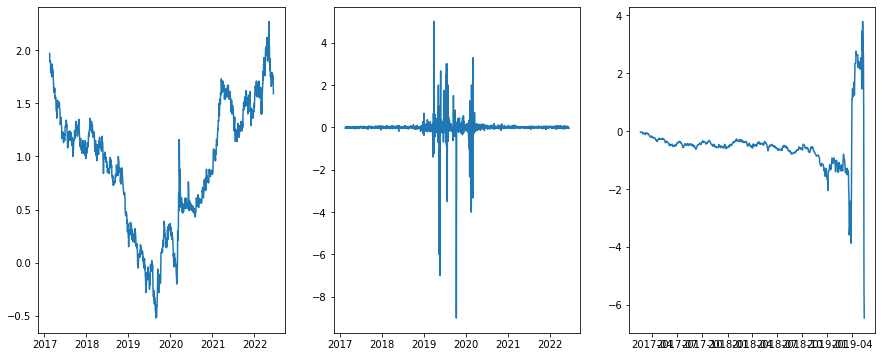

Recession Indicator


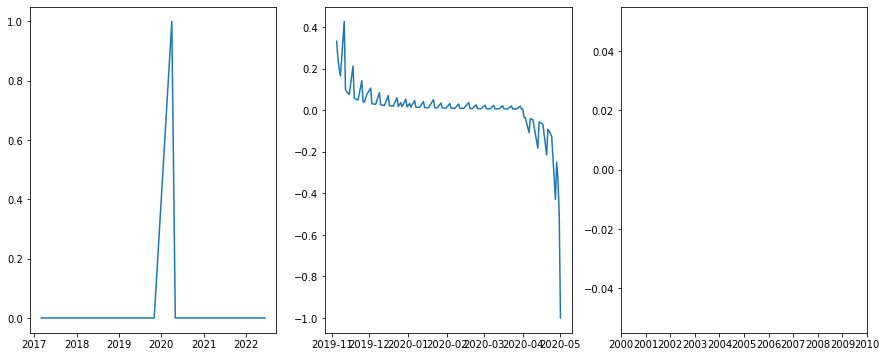

In [49]:
fred_friendly_names = ['Market volatility','Consumer Confidence','Unemployment','Inflation','Interest Rates','10 Year to 3 Month','Recession Indicator']
fred_names = ['VIXCLS','UMCSENT','UNRATE','FPCPITOTLZGUSA','FEDFUNDS','T10Y3M','USREC']
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos])
    name = fred_names[pos]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    plt.show()

In [56]:
screener['vol_30d_2yr']

,vol_30d_2yr,vol_30d_2yr
Symbol,,
ACC,13781055000.0,13781055000.0
MTOR,7888381900.0,7888381900.0
Y,828602100.0,828602100.0
TWI,5400736000.0,5400736000.0
PBF,47517805800.0,47517805800.0
...,...,...
DOUG,NaN,NaN
KD,NaN,NaN
OGN,NaN,NaN


In [53]:
client = Client('192.168.3.100:8786')

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

batchClearLimit = round(len(list__)/7)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 
decision_metrics = []

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,"""
for s in list__:
#for s in ['CEIX']:
    msize = 2

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener.loc[s].dropna()).T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']])

    subset=prices[prices['Symbol']==s].reindex(nyse_dates.index).interpolate(method='time')

    dates = []
    for t in subset.index.values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal    

    lookup_index_ = []

    labels = list()
    print("symbol:",s)   

    try:
        symbol_sector = dict_sectors[sector_merged[sector_merged['Symbol']==s]['Sector'].values[0]]
        print("sector:",dict_sectors_reverse[symbol_sector])
    except:
        if(symbol_sector=='error'):
            if(np.sum([vanguard_sectors['Symbol'].values==s])):
                symbol_sector = s
                print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
    if(symbol_sector=='error'):
        if(np.sum([vanguard_sectors['Symbol'].values==s])):
            symbol_sector = s
            print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
            print("sector:",'error')

    symbol_index = temp_sm.loc[s]['index_Symbol']

    try:
        matched_index_name = spdr_indexes.iloc[np.where(spdr_indexes['Symbol'].values==s)].index[0]
    except:
        try:
            matched_index_name = temp_sm.loc[s]['index']
        except:
            matched_index_name = "none"

    print("Index:",matched_index_name)

    print("supply trend:",screener.iloc[np.where(screener.index==s)]['vol_30d_2yr'][0])
    print("risk trend factor:",screener.iloc[np.where(screener.index==s)]['risk_trend_factor'][0])   

    temp = pd.DataFrame(stock_fundamentals.loc[s])
    print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

    last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices[prices['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

    bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
    bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
    bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2
    
    bbands.index = [last_date]
    display(bbands)

    display(metrics_df_)
    
    mean_revert_flag = False
    
    if(metrics_df_['adf'][0]<.05):
        print("ADFuller H0 rejected @ .05, Mean Reverting TS")
        if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
            colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True
        if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
            colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True
    
    fig, ax1 = plt.subplots()   
    
    ax2 = ax1.twinx()
    
    l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', 'risk_trend_factor','linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

    r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

    display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])
    
    if(symbol_sector=='error'):
        pass
    else:
        if(np.sum(vanguard_sectors['Symbol'].values==s)>0):
            pass
        else:
            #print("sector",)
            #print("else_sector:",dict_sectors_reverse[s])
            ax2.plot(x, prices[prices['Symbol']==symbol_sector]['Adj Close'],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))        
            #plt.legend([temp_sm.loc[s]['Sector']])
            #labels_ax2.append(temp_sm.loc[s]['Sector'])
            #plt.show()

    if(str(temp_sm.loc[s]['index_Symbol'])!='nan'):
        if(temp_sm.loc[s]['index_Symbol']!='error'):
            #print(temp_sm.loc[s]['index_Symbol'])
            ax2.plot(x, prices[prices['Symbol']==temp_sm.loc[s]['index_Symbol']]['Adj Close'],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
            #plt.plot()
            #plt.legend([temp_sm.loc[s]['index']])
            #labels_ax2.append(temp_sm.loc[s]['index'])
            #plt.show()

    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    ax1.plot(x, y,marker = '.',markersize=msize, color = 'b')
    ax1.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
    ax1.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
    ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')
    
    ax1.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')
    
    ax1.plot(x, mymodel, color = 'k')
    
    for l in ['symbol','1yrMax','1yrMin','risk_trend_factor','supply_trend_1yr','linear']:
        labels.append(l)
    
    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    
    
    ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
    
    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    plt.show()
    
    print("ets next 13 weeks")

    newDates = pd.date_range(end, (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W').map(lambda t: t.strftime('%Y-%m-%d'))

    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W')

    if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
        client.restart()
        
    cv_inner = TimeSeriesSplit(n_splits=11,test_size=13)
    
    #has to be different makeup than cv_inner because there is no randomization.  Recommend a number that isn't a divisor of cv_inner's n_splits to ensure training is mixed up and not aligned
    cv_outer = TimeSeriesSplit(n_splits=10,test_size=13)
    
    outer_results = list()
     
    func = sm.tsa.statespace.ExponentialSmoothing
    
    flags = [['T','T'],['T','F'],['F','F'],['F','T']]       

    rmses = []
    for flag in flags:

        F1 = flag[0]
        F2 = flag[1]

        npa = []

        for trainv_ix, test_ix in cv_inner.split(data.index):

            npa.append([data.iloc[trainv_ix],data.iloc[test_ix],func,F1,F2])

        future = client.map(evaluate_ets, npa)
        results_rmses = []

        #my intent was to capture future objects vs results and this gave me results
        for f in as_completed(future):
            #exclude errors
            if(f.status=="error"):
                #pass
                results_rmses.append([np.nan])
            else:
                results_rmses.append(f.result()) 

        rmse_ = [r[0] for r in results_rmses].copy()

        rmses.append([[flag],rmse_])

    rmse_TT = [r for r in rmses[0]][1]
    rmse_TF = [r for r in rmses[1]][1]
    rmse_FF = [r for r in rmses[2]][1]
    rmse_FT = [r for r in rmses[3]][1]

    scores = [np.nanmean(rmse_TT),np.nanmean(rmse_FT),np.nanmean(rmse_TF),np.nanmean(rmse_FF)]
    sdevs = [np.nanstd(rmse_TT),np.nanstd(rmse_FT),np.nanstd(rmse_TF),np.nanstd(rmse_FF)]
    print("inner cv scores:",scores)
    print("inner cv sdevs:",sdevs)

    best_model = flags[np.argmin(scores)]

    print("best model:",best_model)
    print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

    if(best_model==['T', 'T']):
        flag_ = flags[0]
    elif(best_model==['T', 'F']):
        flag_ = flags[1]
    elif(best_model==['F', 'F']):
        flag_ = flags[2]
    elif(best_model==['F', 'T']): 
        flag_ = flags[3]
    else:
        pass
    npa = []

    F1 = flag_[0]
    F2 = flag_[1]

    for trainv_ix, test_ix in cv_outer.split(data.index):

        npa.append([data.iloc[trainv_ix],data.iloc[test_ix],func,F1,F2])

    future = client.map(evaluate_ets, npa)
    results_rmses = []

    #my intent was to capture future objects vs results and this gave me results
    for f in as_completed(future):
        #exclude errors
        if(f.status=="error"):
            #pass
            results_rmses.append([np.nan])
        else:
            results_rmses.append(f.result()) 

    rmse_ = [r[0] for r in results_rmses].copy()

    test_score = [np.nanmean(rmse_),np.nanstd(rmse_)]
    print("test cv mean error, stdev (10 folds):",test_score)
    
    final_model=func(np.log(data),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()
    
    pred = final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d'))
    df_pred = np.exp(pred.summary_frame(alpha=0.05))
    s_date = df_pred.index[np.argmax(df_pred['mean'].values)].strftime('%Y-%m-%d')
    
    print("sell date:",s_date)
    e_return = np.array((np.max(df_pred['mean'].values)-metrics_df_['latest_p'])/metrics_df_['latest_p'])[0]
    
    print("expected return:",e_return)
        
    days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
    discounted_return = (1+e_return)**(1/days_delta)-1
    qtr_return = (1+discounted_return)**92

    print("discounted return:",discounted_return)
    
    print("quarter return:",qtr_return)
    
    #used to help filter at the end, not sdevs is chosen based on min score
    decision_metrics.append([s,e_return,s_date,days_delta,discounted_return,qtr_return,test_score[0],test_score[1],mean_revert_flag])
    
    plt.plot(data.tail(13))
    plt.plot(df_pred[['mean','mean_ci_lower','mean_ci_upper']])
    plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
    plt.show()

    if(np.sum(np.array(fundamental_entries)==s)>0):
        loc = np.where(np.array(fundamental_entries)==s)[0][0]
        #print(fundamentals_quarterlies[loc[0]][0])
        #fundamentals_quarterlies[loc][1]
        for item in fundamentals_quarterlies[loc][1]:
            if(type(item[1]) == type(None)):
                pass
            else:
                if(len(item[1])>0):
                    #print(len(item[1]))
                    print(item)
client.close()    

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.
symbol: SPY
sector: error
sector: error
Index: SP500


KeyError: 0

In [ ]:
decision_metrics_df = pd.DataFrame(decision_metrics,columns=['SYMBOL','exp_return','sell_date','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag'])
decision_metrics_df = decision_metrics_df.set_index('SYMBOL').sort_values(by='disc_rtn',ascending=False)
decision_metrics_df['price'] = screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['Sector'] = temp_sm['Sector'].loc[decision_metrics_df.index]
decision_metrics_df['Index'] = temp_sm['index'].loc[decision_metrics_df.index]
decision_metrics_df['error_price_ratio'] = decision_metrics_df['outer_cv_avg_rmse_n11']/screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['std_price_ratio'] = decision_metrics_df['outer_cv_std_n11']/screener['latest_p'].loc[decision_metrics_df.index]

In [ ]:
display(decision_metrics_df.style.applymap(highlight_cells, color_if_false='yellow', color_if_true='#C6E2E9', 
                  subset=['error_price_ratio','mean_revert_flag','std_price_ratio'], threshold_=.75))